In [1]:
%matplotlib inline  
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt
import pylab
import seaborn as sns

/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# 1. Join data together

In [138]:
data_0 = pd.read_csv('../data/Kickstarter000.csv')
data_1 = pd.read_csv('../data/Kickstarter001.csv')
data_2 = pd.read_csv('../data/Kickstarter002.csv')
data_3 = pd.read_csv('../data/Kickstarter003.csv')
data_4 = pd.read_csv('../data/Kickstarter004.csv')
# data_5 = pd.read_csv('Kickstarter005.csv')
# data_6 = pd.read_csv('Kickstarter006.csv')
# data_7 = pd.read_csv('Kickstarter007.csv')
# data_8 = pd.read_csv('Kickstarter008.csv')
# data_9 = pd.read_csv('Kickstarter009.csv')
# data_10 = pd.read_csv('Kickstarter010.csv')
# data_11 = pd.read_csv('Kickstarter011.csv')

In [139]:
success = pd.concat([data_0[data_0['state'] == 'successful'], data_1[data_1['state'] == 'successful'], \
                     data_2[data_2['state'] == 'successful'], \
                     data_3[data_3['state'] == 'successful'], \
                     data_4[data_4['state'] == 'successful']
#                      data_5[data_5['state'] == 'successful'], \
#                      data_6[data_6['state'] == 'successful'], data_7[data_7['state'] == 'successful'], \
#                      data_8[data_8['state'] == 'successful'], data_9[data_9['state'] == 'successful'], \
#                      data_10[data_10['state'] == 'successful'], data_11[data_11['state'] == 'successful'], \
                    ])
fail = pd.concat([data_0[data_0['state'] == 'failed'], data_1[data_1['state'] == 'failed'], \
                  data_2[data_2['state'] == 'failed'], \
                  data_3[data_3['state'] == 'failed'], \
                  data_4[data_4['state'] == 'failed']
#                   data_5[data_5['state'] == 'failed'], \
#                      data_6[data_6['state'] == 'failed'], data_7[data_7['state'] == 'failed'], \
#                      data_8[data_8['state'] == 'failed'], data_9[data_9['state'] == 'failed'], \
#                      data_10[data_10['state'] == 'failed'], data_11[data_11['state'] == 'failed'], \
                    ])

In [140]:
print success.shape, success['state'].unique()
print fail.shape, fail['state'].unique()

(6018, 32) ['successful']
(11416, 32) ['failed']


In [141]:
print fail['blurb'].head()
print success['blurb'].head()

0    MTS ASL Curriculum Workbook is a reproducible ...
1    This kit teaches how to print, correct an ugly...
2    Establishing a free, world-class, public libra...
3    Goal: Introducing a new word into the English ...
4    Zu den Artikeln der DSGVO sind die korrespondi...
Name: blurb, dtype: object
180    We are making a new album of all new songs at ...
181    I am recording my next album and, with your he...
182    For the last two years I have been pouring my ...
183    With 90 minutes of original music & only a 5 t...
184    This is it folks.  Our debut album.  2 years o...
Name: blurb, dtype: object


# 2. Use json to extract the category

In [142]:
import json

def parse_json(cell, key):
    try:
        return str(json.loads(cell)[key])
    except UnicodeEncodeError as e:
        print e
        print cell
        return json.loads(cell)[key]
    except TypeError as e:
        print e
        print cell
        return 'na'

fail['category'].head()

0    {"urls":{"web":{"discover":"http://www.kicksta...
1    {"urls":{"web":{"discover":"http://www.kicksta...
2    {"urls":{"web":{"discover":"http://www.kicksta...
3    {"urls":{"web":{"discover":"http://www.kicksta...
4    {"urls":{"web":{"discover":"http://www.kicksta...
Name: category, dtype: object

In [143]:
fail_category = map(parse_json, fail.iloc[:]['category'], ['name']*len(fail))
print len(fail_category)
print fail['category'].shape
print fail_category[0:5]

11416
(11416,)
['Academic', 'Academic', 'Academic', 'Academic', 'Academic']


In [144]:
fail['cat'] = fail_category
print fail['cat'].head()
print fail['cat'].tail()
print fail['state'].unique()

0    Academic
1    Academic
2    Academic
3    Academic
4    Academic
Name: cat, dtype: object
4115    Apps
4116    Apps
4117    Apps
4118    Apps
4119    Apps
Name: cat, dtype: object
['failed']


In [145]:
success_category = map(parse_json, success.iloc[:]['category'], ['name']*len(success))
print len(success_category)
print success['category'].shape
print success_category[0:5]

6018
(6018,)
['Country & Folk', 'Country & Folk', 'Country & Folk', 'Country & Folk', 'Country & Folk']


In [146]:
success['cat'] = success_category
print success['cat'].head()
print success['cat'].tail()
print success['state'].unique()

180    Country & Folk
181    Country & Folk
182    Country & Folk
183    Country & Folk
184    Country & Folk
Name: cat, dtype: object
3481    Apps
3482    Apps
3483    Apps
3484    Apps
3485    Apps
Name: cat, dtype: object
['successful']


In [147]:
print len(fail['cat'].unique()), '\n', fail['cat'].unique()
print len(success['cat'].unique()), '\n', success['cat'].unique()

29 
['Academic' 'Places' 'Electronic Music' 'Country & Folk' 'Classical Music'
 'Video Games' 'Webseries' 'Thrillers' 'Narrative Film' 'Web' 'Apps'
 'Gadgets' 'Festivals' 'Plays' 'Musical' 'Flight' 'Spaces' 'Immersive'
 'Experimental' 'Wearables' 'Sound' 'Space Exploration' 'Software' 'Robots'
 'Makerspaces' 'Hardware' 'Fabrication Tools' 'DIY Electronics'
 'Camera Equipment']
25 
['Country & Folk' 'Blues' 'Video Games' 'Shorts' 'Hardware' 'Gadgets'
 'Festivals' 'DIY Electronics' 'Musical' 'Spaces' 'Plays' 'Immersive'
 'Experimental' 'Comedy' 'Web' 'Wearables' 'Space Exploration' 'Sound'
 'Software' 'Makerspaces' 'Robots' 'Flight' 'Fabrication Tools'
 'Camera Equipment' 'Apps']


# 3. Make a list of dataframe with each item in the list being a different category
# Do this for both fail and success

In [13]:
f = lambda x: fail[fail['cat'] == x]

sorted_fail = map(f, fail['cat'].unique())
print sorted_fail[0]['cat'].unique()
print sorted_fail[1]['cat'].unique()

['Academic']
['Places']


In [14]:
s = lambda x: success[success['cat'] == x]


sorted_success = map(s, success['cat'].unique())
print sorted_success[0]['cat'].unique()
print sorted_success[20]['cat'].unique()

['Country & Folk']
['Robots']


In [15]:
for df in sorted_fail:
    print df['state'].unique()

for df in sorted_success:
    print df['state'].unique()

['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['failed']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']
['successful']


# 4. Clean up the blurb(description) and be ready to parse into tf-idf

In [16]:
def review_to_wordlist(i, raw, remove_stopwords=False, join_with_space=False):
        ''' Clean one review with optional removing stop words, & join the output with space. '''

        if pd.isnull(raw):
            print i, ':', raw
        else:
            letters_only = re.sub('[^a-zA-Z]', ' ', raw)
            words = letters_only.lower().split()
            # Make a set of stopwords
            if remove_stopwords:
                stop_words = set(stopwords.words("english"))
                meaningful_words = [w for w in words if not w in stop_words]
            if join_with_space:
                return ' '.join(meaningful_words)
            else:
                return words


def get_all_cleaned(raw, remove_stopwords=False, join_with_space=False):
    ''' Loop through all reviews, and preprocess all reviews. '''

    num_reviews = raw['blurb'].size
    clean_reviews = []
    print 'Category: ', raw['cat'].unique(), 'State: ', raw['state'].unique()
    print "Cleaning and parsing the data set movie reviews...\n"
    for i, raw_item in enumerate(raw['blurb']):
        if i%5000 == 0:
            print 'Review %d of %d\n' %(i, num_reviews)
        clean_reviews.append(review_to_wordlist(i, raw_item, \
                                                    remove_stopwords, \
                                                    join_with_space))

    return clean_reviews

In [17]:
print 'Check for total NaN values: ', sum(pd.isnull(success.iloc[:]['blurb']))
print 'Cleaning success blurb...'
success_blurbs = map(get_all_cleaned, sorted_success, [True]*len(sorted_success), [True]*len(sorted_success))

print 'Cleaning fail blurb...'
fail_blurbs = map(get_all_cleaned, sorted_fail, [True]*len(sorted_fail), [True]*len(sorted_fail))

Check for total NaN values:  0
Cleaning success blurb...
Category:  ['Country & Folk'] State:  ['successful']
Cleaning and parsing the data set movie reviews...

Review 0 of 40

Category:  ['Blues'] State:  ['successful']
Cleaning and parsing the data set movie reviews...

Review 0 of 18

Category:  ['Video Games'] State:  ['successful']
Cleaning and parsing the data set movie reviews...

Review 0 of 120

Category:  ['Shorts'] State:  ['successful']
Cleaning and parsing the data set movie reviews...

Review 0 of 40

Category:  ['Hardware'] State:  ['successful']
Cleaning and parsing the data set movie reviews...

Review 0 of 1078

Category:  ['Gadgets'] State:  ['successful']
Cleaning and parsing the data set movie reviews...

Review 0 of 631

Category:  ['Festivals'] State:  ['successful']
Cleaning and parsing the data set movie reviews...

Review 0 of 291

Category:  ['DIY Electronics'] State:  ['successful']
Cleaning and parsing the data set movie reviews...

Review 0 of 335

Catego

In [18]:
def check_blurb(df):
    new_df = [x for x in df if x is not None]
    print 'Before cleaning: ', len(df)
    print 'After cleaning: ', len(new_df)
    print new_df[0:1]
    print '\n'
    
    
_ = map(check_blurb, success_blurbs)
_ = map(check_blurb, fail_blurbs)

Before cleaning:  40
After cleaning:  40
['making new album new songs bombshelter nashville need help time pressing vinyl']


Before cleaning:  18
After cleaning:  18
['tribute blind willie johnson takes world early blues gospel making star compilation']


Before cleaning:  120
After cleaning:  120
['compendium four joyfully fun local multiplayer games playstation home computers']


Before cleaning:  40
After cleaning:  40
['sometimes bullying needs taken care baseball bat']


Before cleaning:  1078
After cleaning:  1078
['turning dna data became affordable biohacking never meet open source real time pcr thermocycler']


Before cleaning:  631
After cleaning:  631
['neo batteries friction extra magnets cool easy mountable scandinavian design based magnetic energy']


Before cleaning:  291
After cleaning:  291
['marks leave new play tyler andrew jones accepted new york fringe fest help us get produced']


Before cleaning:  335
After cleaning:  335
['usb powered wifi iot development board

# 5. Tf-Idf starts here.

In [21]:
# Use tf-idf
def tf_idf_trans(df):
    try:
        if df:
            tf_ = TfidfVectorizer(
                                    min_df=2, \
                                    max_df=0.90, \
                                    max_features=100, \
                                    ngram_range=(1, 4), \
                                    sublinear_tf=True)
            tf_bow = tf_.fit_transform(df)
            print tf_bow.shape
            return (tf_bow, tf_)
    except ValueError as e:
        print 'Dataframe is: ', df
        print e
        return []


success_tf_bow = map(tf_idf_trans, success_blurbs)
fail_tf_bow = map(tf_idf_trans, fail_blurbs)


# success_tf = TfidfVectorizer(min_df=2, \
#                             max_df=0.75, \
#                             max_features=500, \
#                             ngram_range=(1, 4), \
#                             sublinear_tf=True)
# success_tf_bow = success_tf.fit_transform(success_blurbs)
# print success_tf_bow.shape

(40, 94)
(18, 36)
(120, 100)
(40, 53)
(1078, 100)
(631, 100)
(291, 100)
(335, 100)
(406, 100)
(82, 100)
(681, 100)
(140, 100)
(177, 100)
Dataframe is:  ['social science fiction black super pac fund radical projects focused destroying white supremacy']
max_df corresponds to < documents than min_df
(222, 100)
(289, 100)
(99, 100)
(205, 100)
(337, 100)
(66, 100)
(180, 100)
(66, 100)
(50, 100)
(154, 100)
(310, 100)
(20, 15)
(100, 100)
(40, 69)
(20, 25)
(40, 64)
(20, 30)
(20, 17)
(20, 14)
(40, 39)
(2502, 100)
(734, 100)
(1199, 100)
(155, 100)
(415, 100)
(305, 100)
(241, 100)
(78, 100)
(106, 100)
(116, 100)
(462, 100)
(223, 100)
(134, 100)
(1876, 100)
(222, 100)
(104, 100)
(1669, 100)
(124, 100)
(303, 100)
(128, 100)


In [22]:
# Vocab. is saved inside here as Tuple:

print (success_tf_bow[0][1].vocabulary_)

{u'making new': 45, u'worth': 90, u'titled': 84, u'past': 61, u'new': 53, u'full': 26, u'studio': 80, u'new collection': 56, u'music': 47, u'new songs': 58, u'bluegrass band': 12, u'album need help': 3, u'dream': 19, u'help': 34, u'good': 32, u'band': 9, u'debut': 17, u'need help': 51, u'hard': 33, u'record first': 70, u'new album': 54, u'story': 79, u'part': 60, u'project': 63, u'recording': 72, u'ready record': 68, u'nashville': 49, u'last': 36, u'country': 16, u'collection': 14, u'bluegrass': 11, u'ready': 67, u'make': 42, u'album new': 4, u'excited': 21, u'people': 62, u'back': 8, u'support': 81, u'record': 69, u'raising': 65, u'us': 86, u'together': 85, u'time': 83, u'songs': 77, u'young': 93, u'putting': 64, u'work': 89, u'album help': 1, u'video': 87, u'folk': 24, u'based': 10, u'wait': 88, u'love': 41, u'raising money': 66, u'making': 43, u'needs': 52, u'new ep': 57, u'years': 92, u'album years': 6, u'rock': 74, u'year': 91, u'ep': 20, u'album': 0, u'recordings': 73, u'album ne

In [66]:
temp = success_tf_bow[2][0]
print temp.shape
print temp
[ pd.Series(temp[i].toarray().ravel()) for i in np.arange(temp.shape[0]) ]

(120, 100)
  (0, 47)	0.798443860902
  (0, 27)	0.602069265938
  (1, 48)	0.707106781187
  (1, 43)	0.707106781187
  (2, 29)	1.0
  (3, 27)	0.359565572111
  (3, 26)	0.216870449442
  (3, 40)	0.772204580101
  (3, 59)	0.476843678769
  (4, 26)	0.22224552774
  (4, 7)	0.514709096889
  (4, 55)	0.352890537856
  (4, 58)	0.407752847159
  (4, 35)	0.420051307934
  (4, 39)	0.467380202412
  (5, 35)	0.321207562222
  (5, 20)	0.311803095363
  (5, 74)	0.357399328634
  (5, 25)	0.357399328634
  (5, 57)	0.393591095046
  (5, 65)	0.393591095046
  (5, 1)	0.281769624299
  (5, 49)	0.393591095046
  (6, 29)	0.618786282716
  (6, 19)	0.521516674287
  :	:
  (114, 43)	0.67628706071
  (114, 26)	0.292013052848
  (114, 14)	0.67628706071
  (115, 58)	0.460673141977
  (115, 42)	0.50771033155
  (115, 11)	0.552083250502
  (115, 0)	0.474567761245
  (116, 26)	0.293012499623
  (116, 1)	0.485807113572
  (116, 42)	0.59247936239
  (116, 2)	0.571929478702
  (117, 26)	0.313519564405
  (117, 83)	0.61195710512
  (117, 84)	0.726095024242
  

[0     0.000000
 1     0.000000
 2     0.000000
 3     0.000000
 4     0.000000
 5     0.000000
 6     0.000000
 7     0.000000
 8     0.000000
 9     0.000000
 10    0.000000
 11    0.000000
 12    0.000000
 13    0.000000
 14    0.000000
 15    0.000000
 16    0.000000
 17    0.000000
 18    0.000000
 19    0.000000
 20    0.000000
 21    0.000000
 22    0.000000
 23    0.000000
 24    0.000000
 25    0.000000
 26    0.000000
 27    0.602069
 28    0.000000
 29    0.000000
         ...   
 70    0.000000
 71    0.000000
 72    0.000000
 73    0.000000
 74    0.000000
 75    0.000000
 76    0.000000
 77    0.000000
 78    0.000000
 79    0.000000
 80    0.000000
 81    0.000000
 82    0.000000
 83    0.000000
 84    0.000000
 85    0.000000
 86    0.000000
 87    0.000000
 88    0.000000
 89    0.000000
 90    0.000000
 91    0.000000
 92    0.000000
 93    0.000000
 94    0.000000
 95    0.000000
 96    0.000000
 97    0.000000
 98    0.000000
 99    0.000000
 dtype: float64, 0     0

In [97]:
# Convert Scipy sparse matrix to Pandas dataframe
def convert_scipy_to_panda(df):
    try:
        if df != None:
            print type(df[0])
            return pd.DataFrame([ pd.Series(df[0][i].toarray().ravel()) for i in np.arange(df[0].shape[0]) ])

    #         print type(new_df)
    #         print '\n'
    #         print new_df.head()
    except IndexError as e:
        print df
        print e
        return []



# # For fail.
# print type(fail_tf_bow)
# df_tf_fail = pd.DataFrame([ pd.Series(fail_tf_bow[i].toarray().ravel()) \
#                               for i in np.arange(fail_tf_bow.shape[0]) ])
# print type(df_tf_fail)

# # For success.
# df_tf_success = pd.DataFrame([ pd.Series(success_tf_bow[i].toarray().ravel()) \
#                               for i in np.arange(success_tf_bow.shape[0]) ])
# print type(df_tf_success)

In [98]:
conv_success_tf_bow = map(convert_scipy_to_panda, success_tf_bow)
conv_fail_tf_bow = map(convert_scipy_to_panda, fail_tf_bow)

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
[]
list index out of range
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.cs

In [102]:
# Just checking the top 10 for the 1st category for both success and fail.

def sort_by_freq(df):
    try:
        top_ten = df.sum(axis=0).sort_values(ascending=False)
        print top_ten.head(10)
        print top_ten.index[0:10]
        return top_ten
    except AttributeError as e:
        print 'dataframe is: ', df

top_ten_tf_success_index = map(sort_by_freq, conv_success_tf_bow)
top_ten_tf_fail_index = map(sort_by_freq, conv_fail_tf_bow)



# top_ten_tf_fail = conv_fail_tf_bow[0].sum(axis=0).sort_values(ascending=False)
# print top_ten_tf_fail
# print top_ten_tf_fail.index[0:10]

# top_ten_tf_success = conv_success_tf_bow[0].sum(axis=0).sort_values(ascending=False)
# print top_ten_tf_success
# print top_ten_tf_success.index[0:10]

0     3.792335
53    3.653151
34    3.384865
69    3.178531
77    2.529979
47    2.400728
20    2.081958
50    1.986410
51    1.986410
92    1.929757
dtype: float64
Int64Index([0, 53, 34, 69, 77, 47, 20, 50, 51, 92], dtype='int64')
3     3.180122
0     2.341227
22    1.832428
19    1.704713
2     1.572200
21    1.389641
12    1.325527
31    1.294890
33    1.204481
20    1.134236
dtype: float64
Int64Index([3, 0, 22, 19, 2, 21, 12, 31, 33, 20], dtype='int64')
26    12.196108
99     6.259836
55     5.473406
1      5.444570
27     5.154344
79     4.938834
58     4.581662
20     4.095421
70     4.078835
75     3.902204
dtype: float64
Int64Index([26, 99, 55, 1, 27, 79, 58, 20, 70, 75], dtype='int64')
10    4.821854
36    2.997754
50    2.455871
37    2.337580
41    2.153883
26    2.102757
40    2.027434
22    1.969518
47    1.953546
16    1.866732
dtype: float64
Int64Index([10, 36, 50, 37, 41, 26, 40, 22, 47, 16], dtype='int64')
98    37.088079
35    36.328201
80    36.120538
6     34.858645

In [103]:
def reverse_dict(df):
    try:
        print df[1].vocabulary_
        new_df = {v: k for k, v in df[1].vocabulary_.iteritems()}
        print '\n', new_df
        return new_df
    except TypeError as e:
        print e, '\n'
        print 'dataframe is: ', df
    except IndexError as e:
        print e, '\n'
        print 'dataframe is: ', df
        
        
        
# # Reverse dictionary for Fail, and print top 10 words.
# print fail_tf.vocabulary_
# new_tf_fail = {v: k for k, v in fail_tf.vocabulary_.iteritems()}
# print '\n', new_tf_fail


# # Reverse dictionary for Success, and print top 10 words.
# print success_tf.vocabulary_
# new_tf_success = {v: k for k, v in success_tf.vocabulary_.iteritems()}
# print '\n', new_tf_success

In [104]:
new_tf_success_dict = map(reverse_dict, success_tf_bow)
new_tf_fail_dict = map(reverse_dict, fail_tf_bow)

{u'making new': 45, u'worth': 90, u'titled': 84, u'past': 61, u'new': 53, u'full': 26, u'studio': 80, u'new collection': 56, u'music': 47, u'new songs': 58, u'bluegrass band': 12, u'album need help': 3, u'dream': 19, u'help': 34, u'good': 32, u'band': 9, u'debut': 17, u'need help': 51, u'hard': 33, u'record first': 70, u'new album': 54, u'story': 79, u'part': 60, u'project': 63, u'recording': 72, u'ready record': 68, u'nashville': 49, u'last': 36, u'country': 16, u'collection': 14, u'bluegrass': 11, u'ready': 67, u'make': 42, u'album new': 4, u'excited': 21, u'people': 62, u'back': 8, u'support': 81, u'record': 69, u'raising': 65, u'us': 86, u'together': 85, u'time': 83, u'songs': 77, u'young': 93, u'putting': 64, u'work': 89, u'album help': 1, u'video': 87, u'folk': 24, u'based': 10, u'wait': 88, u'love': 41, u'raising money': 66, u'making': 43, u'needs': 52, u'new ep': 57, u'years': 92, u'album years': 6, u'rock': 74, u'year': 91, u'ep': 20, u'album': 0, u'recordings': 73, u'album ne

In [129]:
def print_top_words(category, sorted_index, sorted_dict):
    try:
        print '--> Category: ', category
        print '\nTop 10 words for campaigns: '
        words = {}
        for index in sorted_index.index[0:10]:
            print index, ':', sorted_dict[index], ':', sorted_index[index]
            words[sorted_dict[index]] = sorted_index[index]
        print '\n'
        return words
    except AttributeError as e:
        print 'dataframe is: ', sorted_index, '\n'
    except KeyError as e:
        print category


# print '\nTop 20 words for failed campaigns: '
# fail_words = []
# for index in top_ten_tf_fail.index[0:20]:
#     print new_tf_fail[index]
#     fail_words.append(new_tf_fail[index])
    
# print '\nTop 20 words for successful campaigns: '
# success_words = []
# for index in top_ten_tf_success.index[0:20]:
#     print new_tf_success[index]
#     success_words.append(new_tf_success[index])

In [130]:
success_top_10_dict = map(print_top_words, success['cat'].unique(), top_ten_tf_success_index, new_tf_success_dict)

--> Category:  Country & Folk

Top 10 words for campaigns: 
0 : album : 3.79233541206
53 : new : 3.65315067583
34 : help : 3.38486527565
69 : record : 3.17853098038
77 : songs : 2.52997948275
47 : music : 2.40072804416
20 : ep : 2.08195753568
50 : need : 1.9864102673
51 : need help : 1.9864102673
92 : years : 1.9297566023


--> Category:  Blues

Top 10 words for campaigns: 
3 : blues : 3.18012190018
0 : album : 2.34122699344
22 : new : 1.83242799111
19 : music : 1.70471327685
2 : band : 1.57219959013
21 : need : 1.389640643
12 : help : 1.32552658103
31 : star : 1.29489014757
33 : want : 1.20448115853
20 : musicians : 1.13423646172


--> Category:  Video Games

Top 10 words for campaigns: 
26 : game : 12.1961084653
99 : world : 6.259836094
55 : pc : 5.47340625568
1 : adventure : 5.44457029992
27 : games : 5.15434444031
79 : space : 4.93883407313
58 : platformer : 4.58166205393
20 : explore : 4.0954212573
70 : rpg : 4.07883519679
75 : set : 3.9022036559


--> Category:  Shorts

Top 10 wo

In [202]:
fail_top_10_dict = map(print_top_words, fail['cat'].unique(), top_ten_tf_fail_index, new_tf_fail_dict)

--> Category:  Academic

Top 10 words for campaigns: 
11 : school : 2.5331140892
0 : book : 2.22935830282
13 : students : 1.89552349288
12 : skills : 1.54501539894
3 : create : 1.35959372326
8 : important : 1.34811843807
5 : free : 1.3175822655
1 : build : 1.31578356782
14 : world : 1.28445705038
2 : com : 1.1878257535


--> Category:  Places

Top 10 words for campaigns: 
57 : photography : 7.70591830411
59 : photos : 4.98220542523
63 : project : 4.55652591571
51 : photo : 4.36585217754
11 : book : 4.03782744269
60 : places : 3.70689733842
9 : beautiful : 3.64523561329
36 : like : 3.62773095297
10 : beauty : 3.5279362979
77 : share : 3.39583808947


--> Category:  Electronic Music

Top 10 words for campaigns: 
0 : album : 3.68003468728
38 : music : 2.83824777849
49 : project : 2.52043886351
41 : new : 2.22641192002
27 : help : 1.97154914002
67 : want : 1.86243662872
4 : cd : 1.75562072868
52 : release : 1.68191534413
20 : funding : 1.50128342222
35 : make : 1.45476819935


--> Category

In [152]:
success_top_10_dict[0]

{u'album': 3.7923354120648791,
 u'ep': 2.0819575356848521,
 u'help': 3.3848652756522419,
 u'music': 2.4007280441550671,
 u'need': 1.98641026729654,
 u'need help': 1.98641026729654,
 u'new': 3.6531506758298273,
 u'record': 3.1785309803840418,
 u'songs': 2.5299794827465583,
 u'years': 1.9297566023000525}

In [154]:
success_cat_dict = {}
for i, s in enumerate(success['cat'].unique()):
    success_cat_dict[s] = i
print success_cat_dict

{'Web': 14, 'Plays': 10, 'Apps': 24, 'Comedy': 13, 'Hardware': 4, 'Fabrication Tools': 22, 'Flight': 21, 'Shorts': 3, 'Space Exploration': 16, 'Video Games': 2, 'Robots': 20, 'Immersive': 11, 'Country & Folk': 0, 'Sound': 17, 'Makerspaces': 19, 'Musical': 8, 'Experimental': 12, 'Software': 18, 'Festivals': 6, 'Wearables': 15, 'DIY Electronics': 7, 'Gadgets': 5, 'Spaces': 9, 'Camera Equipment': 23, 'Blues': 1}


In [155]:
fail_cat_dict = {}
for i, s in enumerate(fail['cat'].unique()):
    fail_cat_dict[s] = i
print fail_cat_dict

{'Web': 9, 'Plays': 13, 'Apps': 10, 'Classical Music': 4, 'Hardware': 25, 'Fabrication Tools': 26, 'Flight': 15, 'Makerspaces': 24, 'Space Exploration': 21, 'Video Games': 5, 'Robots': 23, 'Immersive': 17, 'Country & Folk': 3, 'Narrative Film': 8, 'Electronic Music': 2, 'Sound': 20, 'Places': 1, 'Webseries': 6, 'Academic': 0, 'Thrillers': 7, 'Musical': 14, 'Experimental': 18, 'Software': 22, 'Wearables': 19, 'DIY Electronics': 27, 'Gadgets': 11, 'Spaces': 16, 'Camera Equipment': 28, 'Festivals': 12}


In [157]:
same_cat_list = []
for f in fail['cat'].unique():
    for s in success['cat'].unique():
        if f == s:
            same_cat_list.append(f)

In [162]:
same_cat_list

['Country & Folk',
 'Video Games',
 'Web',
 'Apps',
 'Gadgets',
 'Festivals',
 'Plays',
 'Musical',
 'Flight',
 'Spaces',
 'Immersive',
 'Experimental',
 'Wearables',
 'Sound',
 'Space Exploration',
 'Software',
 'Robots',
 'Makerspaces',
 'Hardware',
 'Fabrication Tools',
 'DIY Electronics',
 'Camera Equipment']

In [169]:
# print success_cat_dict['Country & Folk']
print success_top_10_dict[success_cat_dict['Country & Folk']]

print '\n'
# print fail_cat_dict['Country & Folk']
print fail_top_10_dict[fail_cat_dict['Country & Folk']]

{u'album': 3.7923354120648791, u'help': 3.3848652756522419, u'need help': 1.98641026729654, u'years': 1.9297566023000525, u'record': 3.1785309803840418, u'music': 2.4007280441550671, u'need': 1.98641026729654, u'new': 3.6531506758298273, u'ep': 2.0819575356848521, u'songs': 2.5299794827465583}


{u'album': 2.1711416638271444, u'help': 2.9354730833748723, u'song': 1.8152386557783702, u'country': 2.6084171803393077, u'project': 1.9419198243399562, u'record': 2.1668649654773309, u'music': 2.3535272984804236, u'new': 1.4476424517567994, u'ep': 1.6589554050631501, u'songs': 1.4925221960514508}


In [196]:
print type(success_top_10_dict[success_cat_dict['Country & Folk']].values())
print type(success_top_10_dict[success_cat_dict['Country & Folk']].keys())
print type(range(0, 9))
key_list = []
for key in success_top_10_dict[success_cat_dict['Country & Folk']].keys():
    key_list.append(str(key))
print key_list

<type 'list'>
<type 'list'>
<type 'list'>
['album', 'help', 'need help', 'years', 'record', 'music', 'need', 'new', 'ep', 'songs']


<Container object of 10 artists>

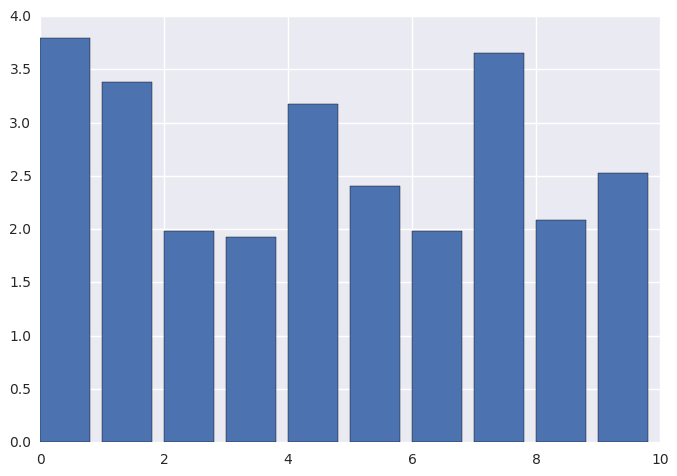

In [201]:
plt.bar(range(0,10), success_top_10_dict[success_cat_dict['Country & Folk']].values())

In [160]:
fail_top_10_dict

[{u'book': 2.2293583028231065,
  u'build': 1.3157835678200607,
  u'com': 1.1878257534989718,
  u'create': 1.3595937232598567,
  u'free': 1.3175822654958935,
  u'important': 1.3481184380709583,
  u'school': 2.5331140892008031,
  u'skills': 1.5450153989387281,
  u'students': 1.8955234928796232,
  u'world': 1.2844570503761734},
 {u'beautiful': 3.6452356132915988,
  u'beauty': 3.5279362978959852,
  u'book': 4.0378274426892098,
  u'like': 3.6277309529662709,
  u'photo': 4.3658521775385122,
  u'photography': 7.7059183041124637,
  u'photos': 4.9822054252257777,
  u'places': 3.7068973384194304,
  u'project': 4.5565259157142677,
  u'share': 3.3958380894701334},
 {u'album': 3.6800346872810237,
  u'cd': 1.7556207286801255,
  u'funding': 1.5012834222196245,
  u'help': 1.9715491400198477,
  u'make': 1.4547681993515427,
  u'music': 2.8382477784937818,
  u'new': 2.2264119200236947,
  u'project': 2.5204388635107908,
  u'release': 1.6819153441262313,
  u'want': 1.8624366287169187},
 {u'album': 2.171141

In [252]:
for value in top_ten_tf_fail.head(20):
    print value

121.925175987
118.468475187
106.918045491
98.460309613
92.1978876336
91.6282248154
88.9618428571
76.1399319464
74.280630191
70.9830852637
70.3712361629
69.8757818774
68.1925931562
67.2515716739
67.0152757927
66.1241885523
65.3830234586
65.0185638036
64.4013421858
64.291432595


In [253]:
for value in top_ten_tf_success.head(20):
    print value

756.20876664
458.797596164
445.948779394
381.398791996
348.908268766
325.122689748
289.991846913
289.952590525
289.911820168
280.148523615
243.49546176
237.961274005
213.137740766
212.095107472
208.85845962
201.417217883
200.624505082
192.725743876
189.255978995
189.014211222


In [250]:
print np.sort(fail_words)
print np.sort(success_words)
repeated = 0
all_words = []
for fail in fail_words:
    for success in success_words:
        if fail == success:
            print fail, success
            repeated += 1
print repeated

[u'com' u'community' u'create' u'find' u'first' u'get' u'help' u'life'
 u'make' u'new' u'one' u'online' u'people' u'platform' u'play' u'site'
 u'social' u'want' u'website' u'world']
[u'art' u'book' u'children' u'first' u'get' u'help' u'life' u'love' u'make'
 u'music' u'new' u'novel' u'one' u'people' u'project' u'stories' u'story'
 u'time' u'us' u'world']
help help
new new
people people
world world
make make
life life
one one
get get
first first
9


In [209]:
# Bag of Words using count.

print "Creating the bag of words for train data...\n"
success_vectorizer = CountVectorizer(analyzer='word', \
                            tokenizer=None, \
                            preprocessor=None, \
                            stop_words=None, \
                            max_features=500)

fail_vectorizer = CountVectorizer(analyzer='word', \
                            tokenizer=None, \
                            preprocessor=None, \
                            stop_words=None, \
                            max_features=500)

success_bag_of_words = success_vectorizer.fit_transform(success_blurbs)
# print success_vectorizer.vocabulary_
print success_bag_of_words.shape
print '\n'

fail_bag_of_words = fail_vectorizer.fit_transform(fail_blurbs)
# print fail_vectorizer.vocabulary_
print fail_bag_of_words.shape

Creating the bag of words for train data...

(17276, 500)


(4747, 500)


In [210]:
# Convert Scipy sparse matrix to Pandas dataframe

# For fail.
print type(fail_bag_of_words)
df_fail = pd.DataFrame([ pd.Series(fail_bag_of_words[i].toarray().ravel()) \
                              for i in np.arange(fail_bag_of_words.shape[0]) ])
print type(df_fail)

# For success.
df_success = pd.DataFrame([ pd.Series(success_bag_of_words[i].toarray().ravel()) \
                              for i in np.arange(success_bag_of_words.shape[0]) ])

<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.frame.DataFrame'>


In [211]:
# print df_temp.sum(axis=0)
top_ten_fail = df_fail.sum(axis=0).sort_values(ascending=False)
print top_ten_fail.index[0:10]

top_ten_success = df_success.sum(axis=0).sort_values(ascending=False)
print top_ten_success.index[0:10]

Int64Index([193, 478, 286, 294, 398, 306, 488, 320, 258, 87], dtype='int64')
Int64Index([56, 206, 297, 488, 164, 415, 27, 78, 304, 249], dtype='int64')


In [213]:
# Reverse dictionary for Fail, and print top 10 words.
print fail_vectorizer.vocabulary_
new_fail = {v: k for k, v in fail_vectorizer.vocabulary_.iteritems()}
print '\n', new_fail

# Reverse dictionary for Success, and print top 10 words.
print success_vectorizer.vocabulary_
new_success = {v: k for k, v in success_vectorizer.vocabulary_.iteritems()}
print '\n', new_success

print '\nTop 10 words for failed campaigns: '
for index in top_ten_fail.index[0:10]:
    print new_fail[index]
print '\nTop 10 words for successful campaigns: '
for index in top_ten_success.index[0:10]:
    print new_success[index]

{u'bringing': 48, u'kids': 222, u'music': 279, u'care': 57, u'brings': 49, u'want': 472, u'travel': 447, u'gaming': 171, u'skills': 394, u'series': 379, u'perform': 308, u'service': 380, u'worlds': 489, u'project': 341, u'person': 311, u'best': 39, u'much': 278, u'pro': 332, u'location': 246, u'life': 235, u'child': 62, u'things': 435, u'big': 41, u'projects': 342, u'online': 294, u'possible': 325, u'unique': 455, u'right': 365, u'old': 292, u'people': 306, u'easy': 121, u'creative': 90, u'support': 420, u'offer': 290, u'talents': 425, u'time': 437, u'connecting': 78, u'team': 427, u'current': 92, u'love': 252, u'working': 486, u'data': 97, u'st': 407, u'years': 497, u'course': 86, u'internet': 215, u'training': 446, u'one': 293, u'vote': 471, u'custom': 93, u'open': 295, u'city': 65, u'future': 167, u'take': 422, u'going': 183, u'jobs': 218, u'many': 264, u'wants': 473, u'photos': 317, u'technology': 428, u'costs': 84, u'summer': 419, u'actors': 5, u'around': 25, u'dark': 96, u'world'